<a href="https://colab.research.google.com/github/JurijJusel/Image/blob/t14-kernel-2filters/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import time
from time import gmtime
from time import strftime

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data


In [ ]:
augmented_data_path = '/content/drive/MyDrive/Colab Notebooks/Image/data/augmented/train/'
validate_data_path = '/content/drive/MyDrive/Colab Notebooks/Image/data/augmented/validate/'

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(augmented_data_path)
validate_data = tf.keras.utils.image_dataset_from_directory(validate_data_path)

Found 3567 files belonging to 2 classes.
Found 603 files belonging to 2 classes.


In [ ]:
data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[1].shape

(32,)

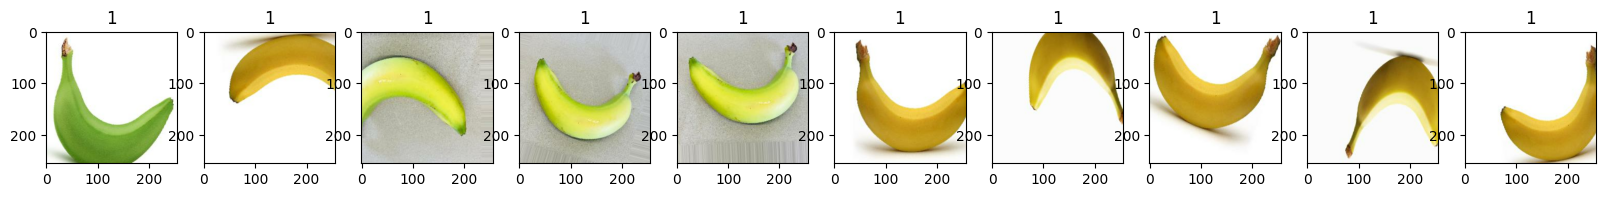

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Proportion of dataset

In [ ]:
def class_balance(dataset):
    class_names = dataset.class_names
    class_counts = [0] * len(class_names)

    for images, labels in dataset:
        for label in labels:
            class_counts[label] += 1

    total_images = sum(class_counts)
    percentages = [count/total_images*100 for count in class_counts]
  
    for name, count, percentage in zip(class_names, class_counts, percentages):
        print(f"Class {name} - {count} images - {percentage:.2f}% of {total_images}")

    if 1 >= min(percentages) / max(percentages) >= 0.8:
        print("This dataset is balanced")
    else:
        print("This dataset is imbalanced")

In [ ]:
class_balance(data)

[50.08291873963516, 49.917081260364846]
Class apple - 302 images - 50.08% of 603
Class banana - 301 images - 49.92% of 603
49.917081260364846
50.08291873963516
This dataset is balanced


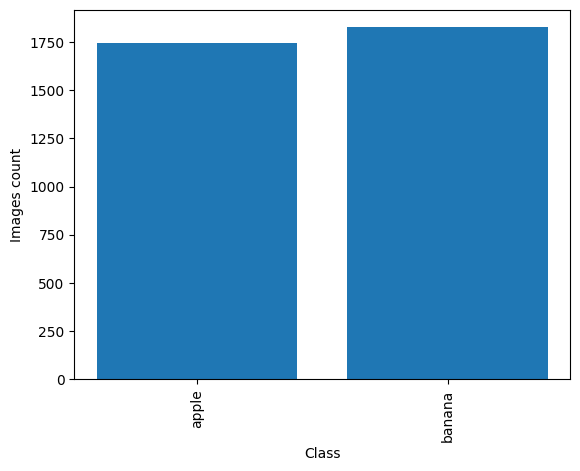

In [ ]:
figure, axes = plt.subplots()
axes.bar(['apple', 'banana'], [1742, 1825])

axes.set_xlabel('Class')
axes.set_ylabel('Images count')
axes.set_xticks(['apple', 'banana'])
axes.set_xticklabels(['apple', 'banana'], rotation=90)

plt.show()


# Data preprocessing

In [ ]:
# Scale Data
data_scale = data.map(lambda x, y:(x/255, y))
validate_data_scale=validate_data.map(lambda x, y:(x/255, y))


In [ ]:
len(data_scale)

112

In [ ]:
train_size = int(len(data_scale)*0.7)
val_size = int(len(data_scale)*0.2)
test_size = int(len(data_scale)*0.1)+1

In [ ]:
train_size

78

In [ ]:
val_size

22

In [ ]:
test_size

12

In [ ]:
train = data_scale.take(train_size)
val = data_scale.skip(train_size).take(val_size)
test = data_scale.skip(train_size+val_size).take(test_size)

In [ ]:
scaled_iterator = data_scale.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].min()

0.0

In [ ]:
batch[0].max()

1.0

In [ ]:
batch[0].shape

(32, 256, 256, 3)

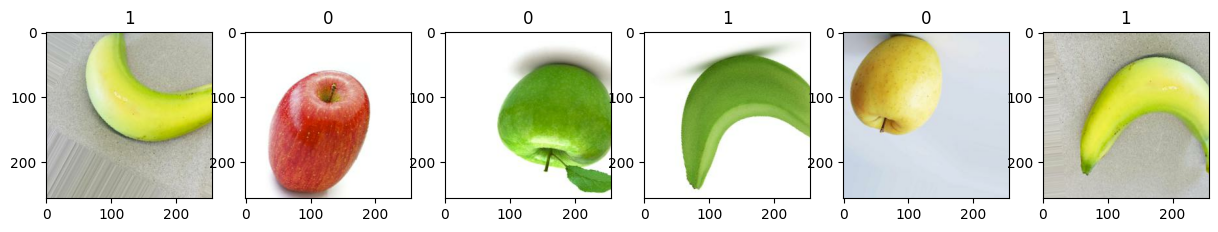

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(15,15))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Build Deep Learning model

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 60, 60, 128)       36992     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 30, 30, 128)    

# Train and save model

In [ ]:
def amount_time(func):
    def stopwatch_timer():
        start_time = time.perf_counter()
        trained_model = func()
        model.save('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model_1.h5')
        stop_time = time.perf_counter()
        duration = stop_time - start_time
        durat_str = strftime("%Hh:%Mm:%Ss", gmtime(duration))
        print(durat_str)
        return trained_model
    return stopwatch_timer

In [ ]:
@amount_time
def train_model():
    return model.fit(data_scale, steps_per_epoch=10, epochs=10, validation_data=validate_data_scale, validation_steps=10, shuffle=True)

In [ ]:
trained_model=train_model()

Epoch 1/10
10/10 [==============================] - 44s 4s/step - loss: 1.5850 - accuracy: 0.5656 - val_loss: 0.4064 - val_accuracy: 0.8094
Epoch 2/10
10/10 [==============================] - 51s 5s/step - loss: 0.3787 - accuracy: 0.8406 - val_loss: 0.3274 - val_accuracy: 0.8125
Epoch 3/10
10/10 [==============================] - 42s 4s/step - loss: 0.2710 - accuracy: 0.8719 - val_loss: 0.1582 - val_accuracy: 0.9406
Epoch 4/10
10/10 [==============================] - 42s 4s/step - loss: 0.1889 - accuracy: 0.9312 - val_loss: 0.2514 - val_accuracy: 0.8875
Epoch 5/10
10/10 [==============================] - 42s 4s/step - loss: 0.2047 - accuracy: 0.9031 - val_loss: 0.1442 - val_accuracy: 0.9406
Epoch 6/10
10/10 [==============================] - 42s 4s/step - loss: 0.1753 - accuracy: 0.9281 - val_loss: 0.0961 - val_accuracy: 0.9750
Epoch 7/10
10/10 [==============================] - 41s 4s/step - loss: 0.1102 - accuracy: 0.9469 - val_loss: 0.0633 - val_accuracy: 0.9750
Epoch 8/10
10/10 [==

In [ ]:
trained_model.history

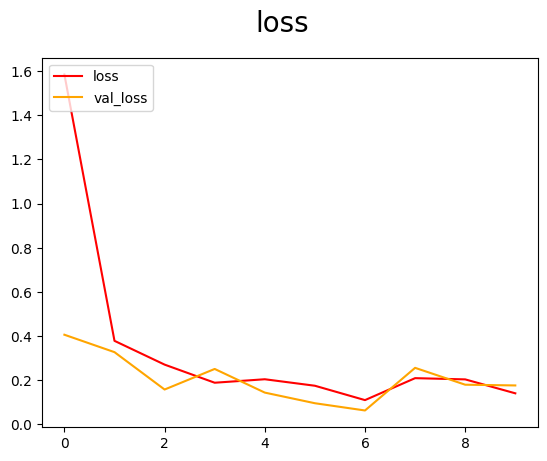

In [ ]:
#Plot Performance
fig=plt.figure()
plt.plot(trained_model.history['loss'], color='red', label='loss')
plt.plot(trained_model.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

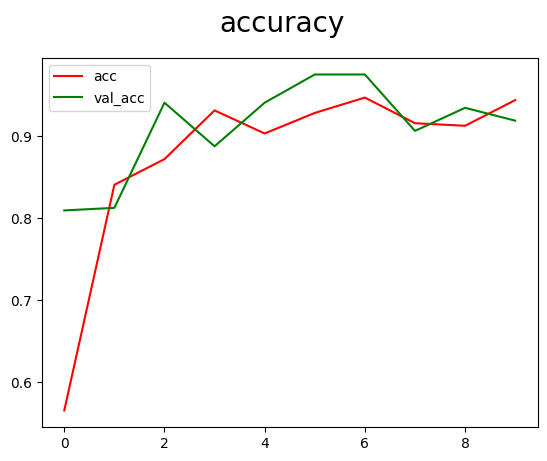

In [ ]:
fig=plt.figure()
plt.plot(trained_model.history['accuracy'], color='red', label='acc')
plt.plot(trained_model.history['val_accuracy'], color='green', label='val_acc')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate Perfomance

In [ ]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model_new.h5')

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in validate_data.as_numpy_iterator():
    X, y = batch
    model_predict = new_model.predict(X)
    pre.update_state(y, model_predict)
    re.update_state(y, model_predict)
    acc.update_state(y, model_predict)

1/1 [==============================] - 3s 3s/step


In [ ]:
pre.result().numpy()

0.9735099

In [ ]:
re.result().numpy()

0.9767442

In [ ]:
acc.result().numpy()

0.97512436

# Test image

In [ ]:
user_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/apple/Image_68.jpg'  # apple
# user_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/banana/Image_96.jpg'  # banana

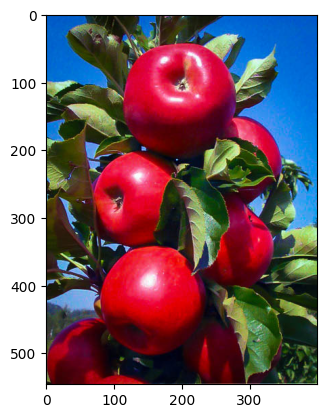

In [ ]:
img_read = cv2.imread(user_image)
plt.imshow(cv2.cvtColor(img_read,cv2.COLOR_BGR2RGB))
plt.show()
# img_path

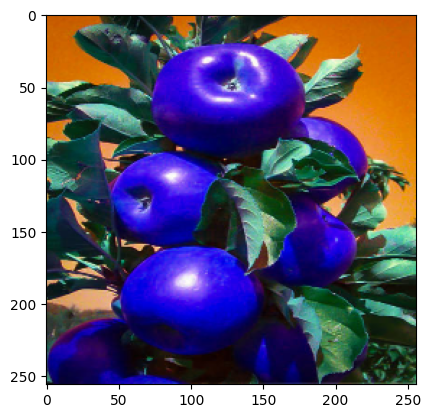

In [ ]:
img_resize = cv2.resize(img_read, (256, 256))
plt.imshow(img_resize)
plt.show()

In [ ]:
# np_exp= np.expand_dims(img_resize,0).shape

In [ ]:
img_array = np.array(img_resize) / 255.0  # normalize pixel values
img_expanded = np.expand_dims(img_array, axis=0)  # expand dimensions to match input shape


# Predict test image


In [ ]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model.h5')

In [ ]:
predictions = new_model.predict(img_expanded, batch_size=10, verbose=0)
predictions

array([[1.5390009e-07]], dtype=float32)

# Confusion matrix

In [ ]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model.h5')

In [ ]:
data_iterator = validate_data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
batch_image = batch[0]
batch_labels = batch[1]

In [ ]:
batch[0].shape, batch[1].shape

((32, 256, 256, 3), (32,))

In [ ]:
y_pred = new_model.predict(batch_image)

1/1 [==============================] - 1s 820ms/step


In [ ]:
cm = confusion_matrix(batch_labels, y_pred)
cm

array([[19,  0],
       [ 0, 13]])

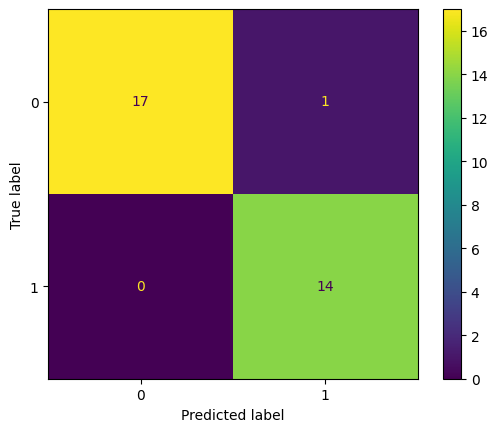

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

Confusion matrix from validate dataset

In [ ]:
test_data = np.concatenate([x for x, y in validate_data], axis=0)
test_label = np.concatenate([y for x, y in validate_data], axis=0)

In [ ]:
y_pred = new_model.predict(test_data).astype(int)

19/19 [==============================] - 16s 853ms/step


In [ ]:
cm = confusion_matrix(test_label, y_pred)
cm

array([[153, 149],
       [153, 148]])

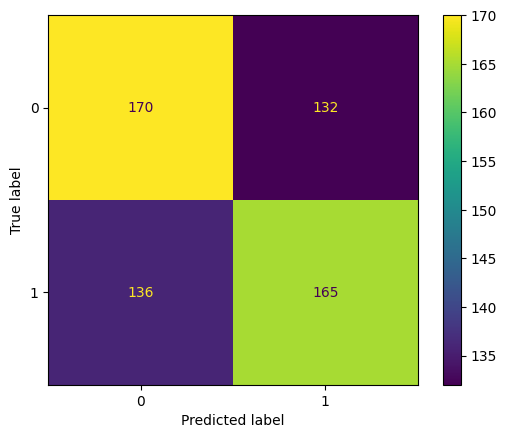

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

# Convolution Kernel

In [ ]:
test_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/apple/Image_56.jpg'

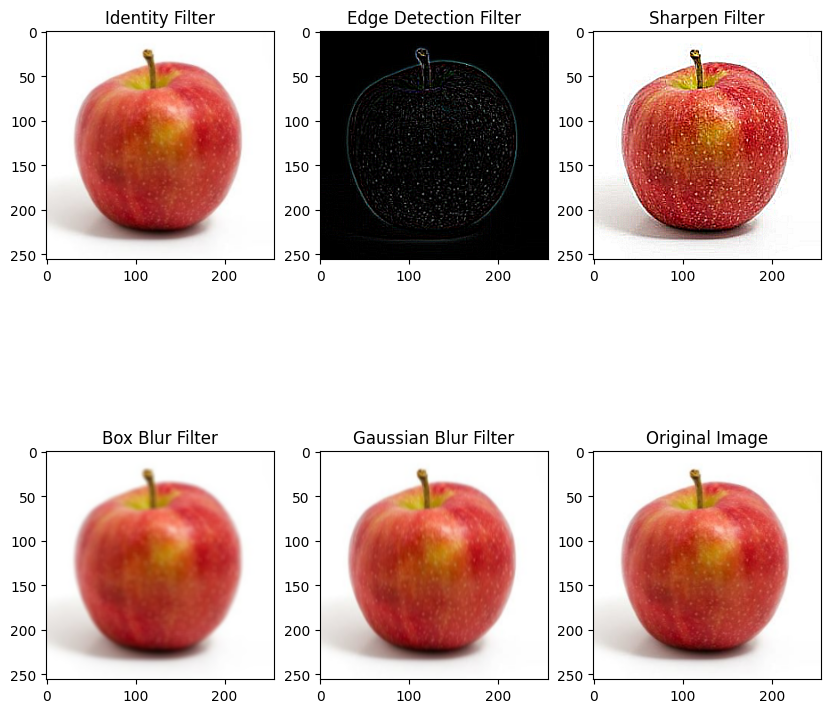

In [ ]:
img_read = cv2.imread(test_image)
img= cv2.resize(img_read , (256, 256))

identity_kernel = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
edge_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
sharpen_kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
box_kernel = np.ones((5, 5),np.float32)/25  
gaussian_kernel = cv2.getGaussianKernel(5, 0)

# Apply the filter kernels to the image
identity = cv2.filter2D(img, -1, identity_kernel)
edge = cv2.filter2D(img, -1, edge_kernel)
sharpen = cv2.filter2D(img, -1, sharpen_kernel)
box_blur = cv2.filter2D(img, -1, box_kernel)
gaussian_blur = cv2.filter2D(img, -1, gaussian_kernel)

# Define the plot layout
fig, axs = plt.subplots(2,3, figsize=(10,10))  # (2,3, figsize=(10,10))

# Display the images in the plot
axs[0, 0].imshow(cv2.cvtColor(identity, cv2.COLOR_BGR2RGB))
axs[0, 1].imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
axs[0, 2].imshow(cv2.cvtColor(sharpen, cv2.COLOR_BGR2RGB))
axs[1, 0].imshow(cv2.cvtColor(box_blur, cv2.COLOR_BGR2RGB))
axs[1, 1].imshow(cv2.cvtColor(gaussian_blur, cv2.COLOR_BGR2RGB))
axs[1, 2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Set the plot titles
axs[0, 0].set_title('Identity Filter')
axs[0, 1].set_title('Edge Detection Filter')
axs[0, 2].set_title('Sharpen Filter')
axs[1, 0].set_title('Box Blur Filter')
axs[1, 1].set_title('Gaussian Blur Filter')
axs[1, 2].set_title('Original Image')

# Display the plot
plt.show()

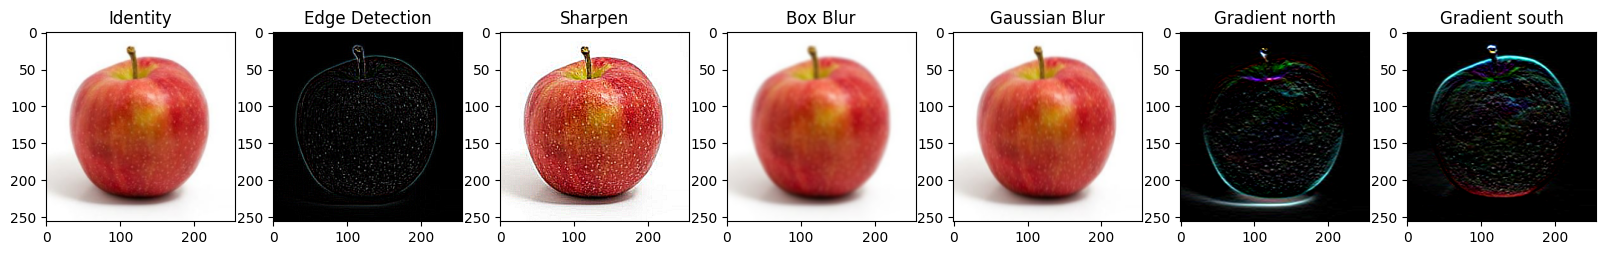

In [ ]:
# read image
img_read = cv2.imread(test_image)
img= cv2.resize(img_read , (256, 256))

# Define the filter kernels
kernels = [
    np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]),  # Identity filter
    np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]),  # Edge detection filter
    np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]]),  # Sharpen filter
    np.ones((5, 5), np.float32) / 25,  # Box blur filter
    cv2.getGaussianKernel(5, 0),  # Gaussian blur filter
    np.array([[-1,-2,-1],[0,0,0],[1,2,1]]), # gradient_north
    np.array([[1,2,1],[0,0,0],[-1,-2,-1]]),  # gradient_south
]

# Apply the filter kernels to the image and store the resulting images in a list
filtered_images = [cv2.filter2D(img, -1, kernel) for kernel in kernels]

# Display the original and filtered images in a plot
fig, axs = plt.subplots(ncols=7, figsize=(20, 20))
titles = ['Identity', 'Edge Detection', 'Sharpen', 'Box Blur', 'Gaussian Blur', 'Gradient north', 'Gradient south']

for i, ax in enumerate(axs.flat):
  ax.imshow(cv2.cvtColor(filtered_images[i], cv2.COLOR_BGR2RGB))
  ax.set_title(titles[i])

plt.show()

# Kernel filters


(256, 256, 3)

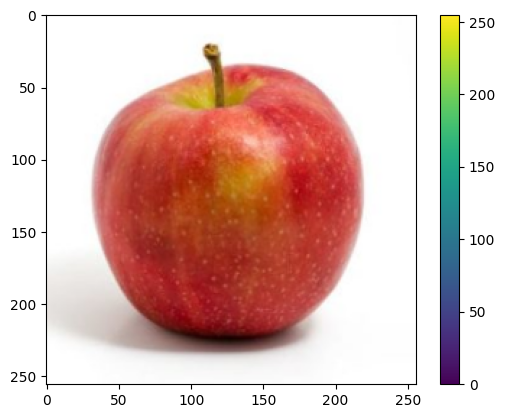

In [4]:
test_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/apple/Image_56.jpg'
img_read = cv2.imread(test_image)
img = cv2.resize(img_read , (256, 256))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.colorbar()
img.shape
# img.dtype  # dtype('uint8')

((256, 256), dtype('uint8'))

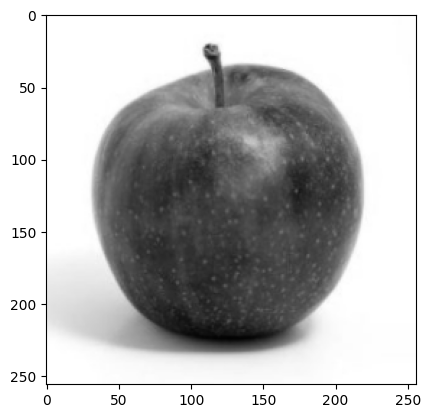

In [5]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB))
# plt.colorbar()
# cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/new111_image.jpg',gray_img)
# plt.imshow(gray_img )
gray_img .shape, gray_img.dtype

In [6]:
# gray_img.shape
gray_img.dtype

dtype('uint8')

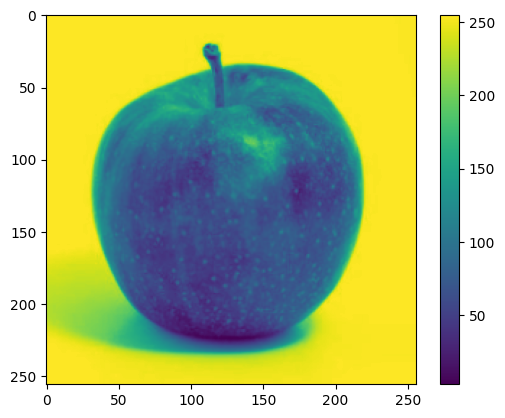

In [7]:
imgplot = plt.imshow(gray_img)
# cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/new111_image.jpg',imgplot)
plt.colorbar()

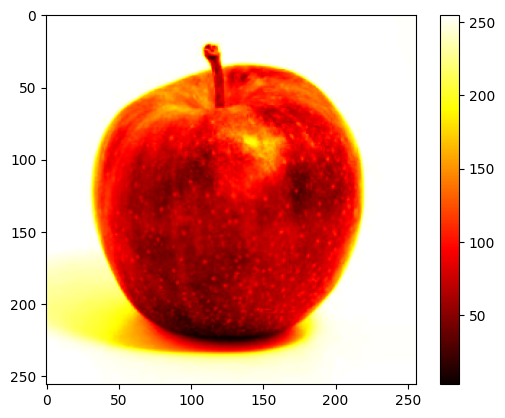

In [8]:
plt.imshow(gray_img, cmap="hot")

plt.colorbar()

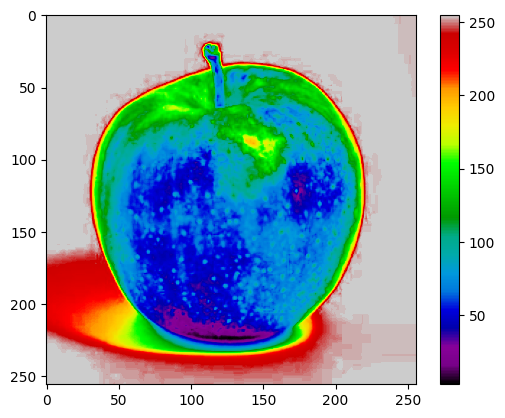

In [11]:
imgplot = plt.imshow(gray_img)#, cmap = 'nipy_spectral')
imgplot.set_cmap('nipy_spectral')

plt.colorbar()

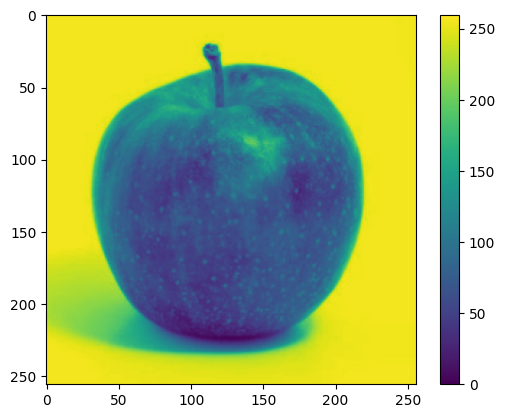

In [12]:
plt.imshow(gray_img, clim=(0, 260))
plt.colorbar()

(296, 300, 3) uint8
0 255


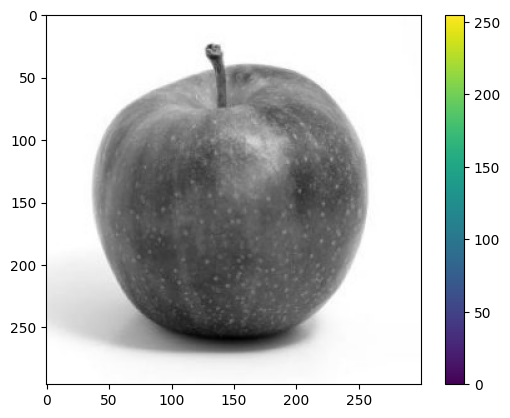

In [37]:
# img_grayscale = cv2.imread(test_image, 0)
# plt.imshow(cv2.cvtColor(img_grayscale, cv2.COLOR_BGR2RGB))

# out_rgb = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
# rgb = cv2.cvtColor(out_rgb, cv2.COLOR_BGR2RGB)
# cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/new111_image.jpg',rgb)
# out_rgb = plt.imshow(cv2.cvtColor(out_rgb, cv2.COLOR_BGR2RGB))
# plt.imshow(img_grayscale)
# io.imshow(out_rgb)

# img= cv2.imread('/content/drive/MyDrive/Colab Notebooks/new111_image.jpg')
# plt.imshow(img)

# original = tf.constant(img)
# plt.imshow(original)
# converted = tf.image.grayscale_to_rgb(img)
# img.shape

# Load grayscale image
# gray_img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/new111_image.jpg', cv2.IMREAD_GRAYSCALE)
# gray_img1 = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)

# # Convert grayscale to BGR
# bgr_img1 = cv2.cvtColor(gray_img1, cv2.COLOR_GRAY2BGR)
# plt.imshow(cv2.cvtColor(bgr_img1, cv2.COLOR_BGR2RGB))
# # Display color image
# plt.imshow(bgr_img1, cmap='jet')
# plt.colorbar()
# plt.show()

color_img1 = np.zeros((gray_img1.shape[0], gray_img1.shape[1], 3), dtype=np.uint8)

# Assign the values of the grayscale image to all 3 channels
# color_img1[:,:,0] = gray_img1
# color_img1[:,:,1] = gray_img1
# color_img1[:,:,2] = gray_img1

# Display color image
# plt.imshow(cv2.cvtColor(color_img1, cv2.COLOR_BGR2RGB))
# plt.imshow(color_img1)
# plt.colorbar()
# plt.show()

norm = cv2.normalize(gray_img1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# print(norm.shape, norm.dtype)

# convert to 3 channel
norm = cv2.cvtColor(norm, cv2.COLOR_GRAY2BGR)
# norm = tf.image.grayscale_to_rgb(norm)
print(norm.shape, norm.dtype)
print(np.amin(norm),np.amax(norm))
# cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/new111444_image.jpg',norm )

plt.imshow(norm)
plt.colorbar()

In [5]:
from skimage import data
from PIL import Image

import skimage.io as io
from skimage import color
from skimage.color import rgb2hed, hed2rgb, gray2rgb, gray2rgba, rgb2lab,rgb2gray

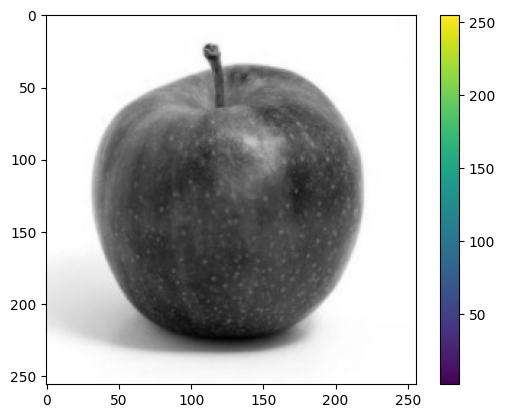

In [63]:
# grayscale = rgb2gray(img)
# # # plt.imshow(grayscale)
# # plt.imshow(grayscale, cmap=plt.cm.gray)
# rgb_img = gray2rgb(grayscale)
# # cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/new111_image.jpg',rgb_img)
# # grayscale.dtype
# rgb_img = rgb2lab(rgb_img)

# # io.imshow(rgb_img)
# rgb_img
image_grayscale = Image.open('/content/drive/MyDrive/Colab Notebooks/new111_image.jpg')
edges = color.gray2rgb(image_grayscale)
# image_rgb = image_grayscale.convert('RGB')
# image_rgb = tf.image.grayscale_to_rgb(gray_img)
# image_rgb.shape#, 
# image_rgb.dtype
# plt.imshow(edges)
# io.imshow(image_rgb)
plt.imshow(cv2.cvtColor(edges , cv2.COLOR_BGR2RGB))
plt.colorbar()

In [57]:
# a = gray2rgb(gray_img, channel_axis=-1)
# a.dtype
# arr_uint8 = grayscale .astype('uint8')
# plt.imshow(cv2.cvtColor(a, cv2.COLOR_BGR2RGB))
# img_rgb = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
# plt.imshow(img_rgb)
# io.imshow(out_rgb)
# plt.colorbar()

# im_pillow = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/new111_image.jpg'))

# im_bgr = cv2.cvtColor(im_pillow, cv2.COLOR_BGR2RGB)
# t = cv2.imread('/content/drive/MyDrive/Colab Notebooks/new111_image.jpg', cv2.IMREAD_COLOR)
# img_rgb = cv2.cvtColor(t, cv2.COLOR_BGR2RGB)
# plt.imshow(img_rgb )
# img_rgb.shape


# print(im_bgr.shape)
# plt.imshow(im_pillow)
# plt.colorbar()

AttributeError: ignored

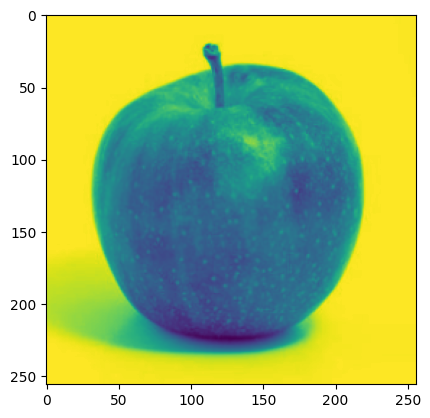

In [90]:
from PIL import Image
# img = np.array(Image.open(test_image).resize((256, 256)))
im_gray = np.array(Image.open(test_image).convert('L'))
img1= cv2.resize(im_gray , (256, 256))
# img.shape
# im_gray.shape
# img1.shape
# im_gray.show()
plt.imshow(img1)

In [41]:
# kernel filters 
edge_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
edge = cv2.filter2D(img, -1, edge_kernel)
sharpen_kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
sharpen = cv2.filter2D(img, -1, sharpen_kernel)

In [42]:
img_shape = img.shape
filter_size = 3

In [43]:
if img_shape[1]%filter_size == 0:
  print('image width ok')
else:
  print('image width false')

image width false


In [44]:
times_filter_slide = (img_shape[0] - filter_size - 1 ) * (img_shape[1] - filter_size - 1)
times_filter_slide

63504

In [45]:
unused_pix = (img_shape[0] * img_shape[1]) - times_filter_slide
unused_pix

2032

In [46]:
edge_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
edge_kernel.shape

(3, 3)

In [47]:
arr = np.array([[4, 3, 2, 2, 0, 0, 2, 0, 4, 1],
                [3, 4, 2, 0, 0, 4, 4, 4, 4, 3],
                [0, 1, 1, 4, 1, 0, 0, 0, 3, 2],
                [1, 2, 1, 0, 2, 3, 2, 0, 3, 4],
                [0, 4, 3, 2, 0, 1, 0, 2, 2, 4],
                [1, 1, 4, 1, 4, 2, 4, 1, 2, 0],
                [0, 3, 0, 3, 4, 1, 1, 0, 0, 3],
                [1, 0, 2, 2, 0, 4, 0, 0, 4, 4],
                [2, 4, 2, 0, 2, 0, 4, 2, 2, 1],
                [1, 2, 3, 3, 4, 2, 4, 3, 0, 0]])
arr.shape


(10, 10)

In [48]:
def kernel_filter(arr, filt):
    # Get the dimensions of the array and filter
    arr_height, arr_width = arr.shape
    filt_height, filt_width = filt.shape

    # Calculate the size of the output array
    out_height = arr_height - filt_height + 1
    out_width = arr_width - filt_width + 1

    # Initialize the output array with zeros
    out = np.zeros((out_height, out_width))

    # Apply the filter to each sliding window in the array
    for i in range(out_height):
        for j in range(out_width):
            window = arr[i:i+filt_height, j:j+filt_width]
            out[i,j] = np.sum(window * filt)

    return out

In [53]:
sharpen_kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
# edge_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

# Apply the filter to the array
# out = kernel_filter(gray_img, edge_kernel)
out = kernel_filter(gray_img, sharpen_kernel)

# Print the output
out = out

In [83]:
# out.shape
# out.dtype
# plt.imshow(out)
# rgb_img = gray2rgb(out, channel_axis=-1)
ImageColor.getrgb(out)
io.imshow(rgb_img)

NameError: ignored

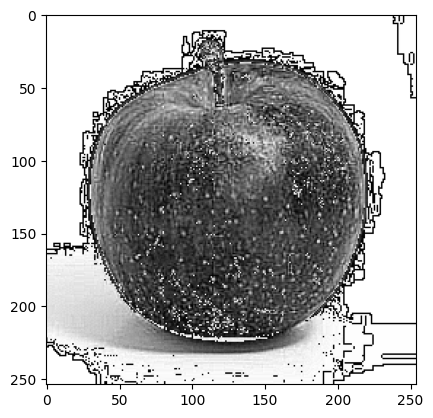

In [61]:
# arr_uint8 = out.astype('uint8')
# img_rgb = cv2.cvtColor(arr_uint8 , cv2.COLOR_BGR2RGB)
# cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/new111_image.jpg',img_rgb)
# # arr_uint8.dtype
# plt.imshow(img_rgb)

In [126]:
img_float32 = np.float32(out)
plt.imshow(cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)  # BGRA2RGB

SyntaxError: ignored

# Arr hist

(50, 50)


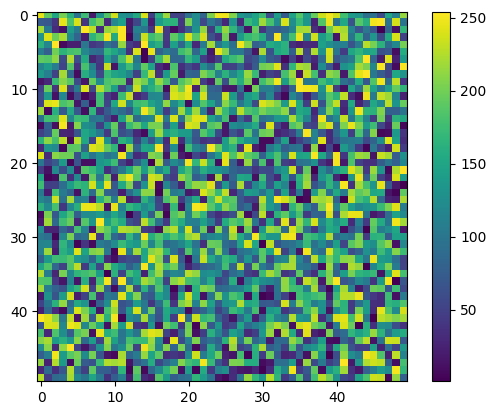

In [50]:
import seaborn as sn

arr = np.random.randint(1, 255, size=(50, 50)).astype('uint8')
print(arr.shape)
plt.imshow(arr)
plt.colorbar()

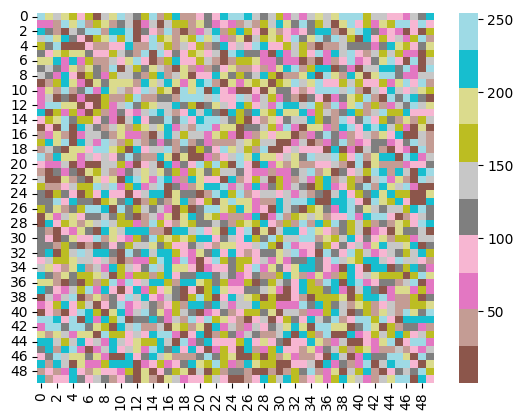

In [60]:
hm = sn.heatmap(data = arr, cmap = "tab20", center = 0)

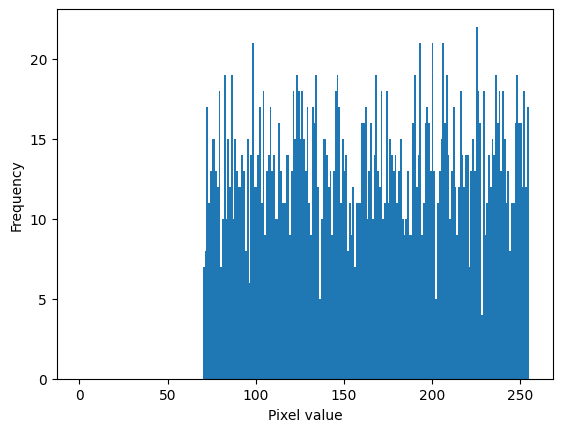

In [34]:
# Plot the histogram
plt.hist(arr.ravel(), bins=256, range=(0, 256))
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()

(50, 50, 3)


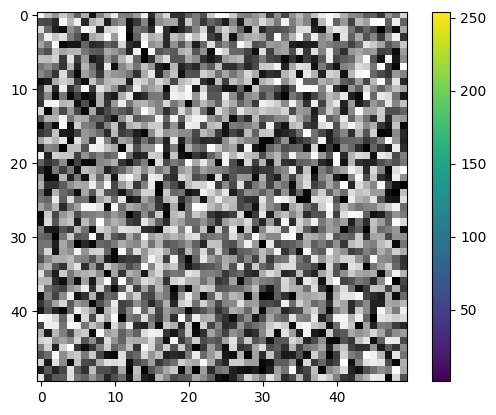

In [53]:
arr_rgb = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
print(arr_rgb.shape)
plt.imshow(arr_rgb)
plt.colorbar()

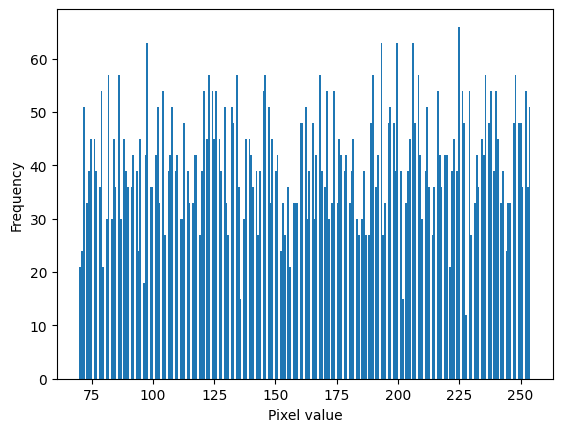

In [36]:
# Plot the histogram
plt.hist(arr_rgb.ravel(), bins=256)#, range=(0, 256))
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()

(50, 50)


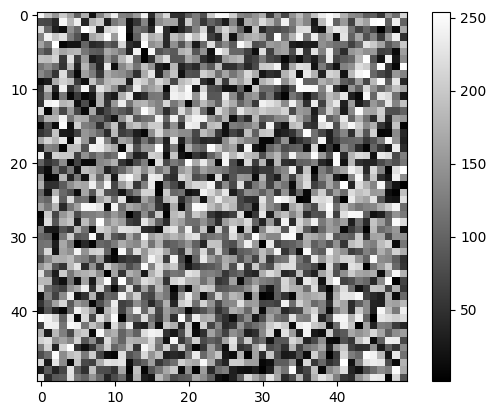

In [56]:
arr_gray = cv2.cvtColor(arr_rgb, cv2.COLOR_RGB2GRAY)
print(arr_gray.shape)
plt.imshow(arr_gray, cmap='gray')
plt.colorbar()

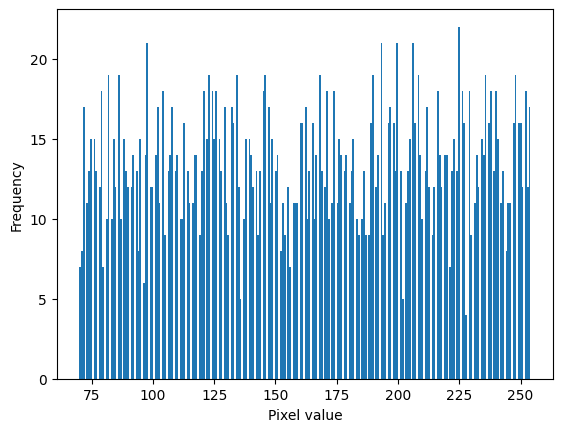

In [38]:
# Plot the histogram
plt.hist(arr_gray.ravel(), bins=256)#, range=(0, 256))
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()

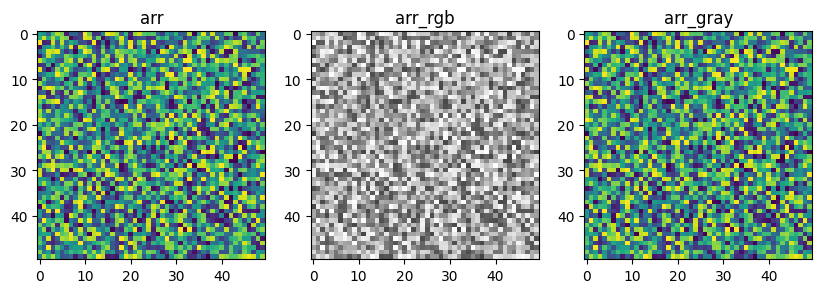

In [39]:
arr_img = [arr, arr_rgb, arr_gray]
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
titles = ['arr', 'arr_rgb', 'arr_gray']

for i, img in enumerate(arr_img):
    axs[i].imshow(img)#, cmap='gray')
    axs[i].set_title(titles[i])  

plt.show()

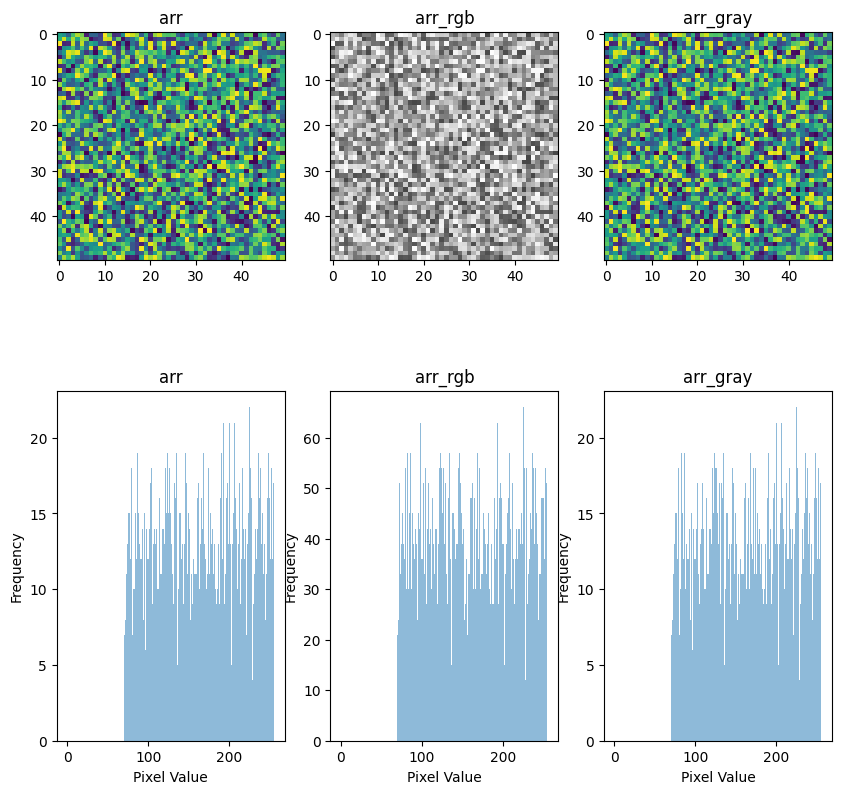

In [40]:
arr_img = [arr, arr_rgb, arr_gray]
fig, axs = plt.subplots(2,3, figsize=(10, 10))
titles = ['arr', 'arr_rgb', 'arr_gray']

for i, img in enumerate(arr_img):
    axs[0,i].imshow(img)#, cmap='gray')
    axs[0,i].set_title(titles[i])
    
    axs[1,i].hist(img.ravel(), bins=256, range=(0, 256), alpha=0.5)  # , color='gray')
    axs[1,i].set_title(titles[i])
    axs[1,i].set_xlabel('Pixel Value')
    axs[1,i].set_ylabel('Frequency')

plt.show()

In [42]:
arr_rgb.shape

(50, 50, 3)

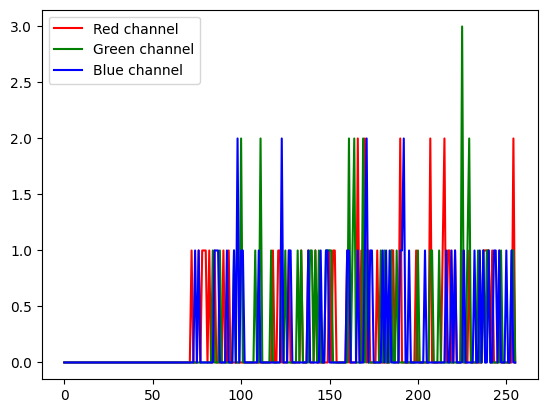

In [47]:
# Compute the histograms of the red, green, and blue channels
hist_r, bins_r = np.histogram(arr[..., 0], bins=256, range=(0, 256))
hist_g, bins_g = np.histogram(arr[..., 1], bins=256, range=(0, 256))
hist_b, bins_b = np.histogram(arr[..., 2] , bins=256, range=(0, 256))

# Plot the histograms
plt.plot(hist_r, 'r')
plt.plot(hist_g, 'g')
plt.plot(hist_b, 'b')
plt.legend(['Red channel', 'Green channel', 'Blue channel'])
plt.show()

In [61]:
from tensorflow.python.ops.array_ops import meshgrid
from numpy.core.function_base import linspace
x_ = np.linspace(-5, 5, 100)
y_ = np.linspace(-5, 5, 100)

X, Y = np.meshgrid(x_, y_)

gaussian = np.exp(-((X**2)/2 + (Y**2)/2))

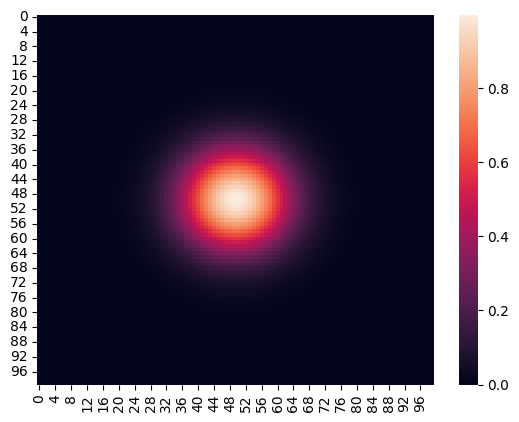

In [96]:
hm = sn.heatmap(data = gaussian)#, cmap = "tab20", center = 0)

In [70]:
gaussian.dtype

dtype('float64')

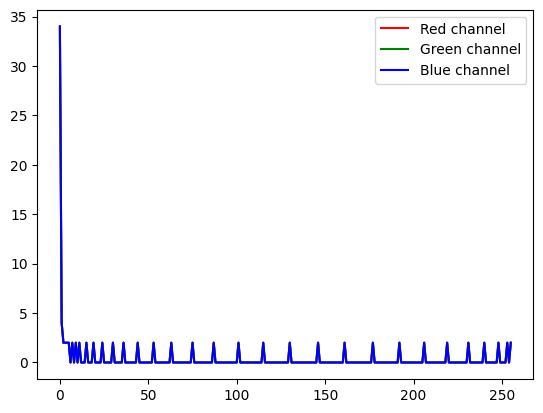

In [93]:
# Compute the histograms of the red, green, and blue channels
hist_r, bins_r = np.histogram(gaussian[..., 0], bins=256)#, range=(0, 256))
hist_g, bins_g = np.histogram(gaussian[..., 1], bins=256)#, range=(0, 256))
hist_b, bins_b = np.histogram(gaussian[..., 2], bins=256)#, range=(0, 256))

# Plot the histograms
plt.plot(hist_r, 'r')
plt.plot(hist_g, 'g')
plt.plot(hist_b, 'b')
plt.legend(['Red channel', 'Green channel', 'Blue channel'])
plt.show()

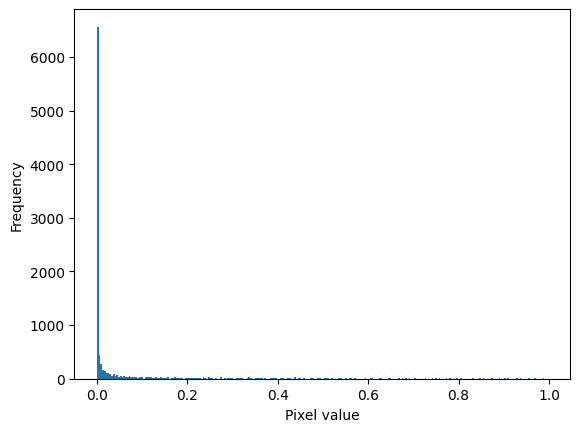

In [87]:
plt.hist(gaussian.ravel(), bins=256)#, range=(0, 256))
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()